<a href="https://colab.research.google.com/github/lcipolina/art/blob/main/prompts/glide_inpaint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLIDE Inpainting 

Official notebook here:

https://github.com/openai/glide-text2im/blob/main/notebooks/inpaint.ipynb


In [1]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im --quiet

     |████████████████████████████████| 53 kB 1.7 MB/s 


In [2]:
#Imports
from typing import Tuple
from IPython.display import display
from PIL import Image
import numpy as np
import torch as th
import torch.nn.functional as F
import cv2

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [ ]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

#has_cuda = th.cuda.is_available()
#device = th.device('cpu' if not has_cuda else 'cuda')
#print(f"Running on {device}")

In [3]:
# Create base model.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

options = model_and_diffusion_defaults()
options['inpaint'] = True
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling

model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base-inpaint', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385037638


In [4]:
# Create upsampler model.

options_up = model_and_diffusion_defaults_upsampler()
options_up['inpaint'] = True
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398368198


In [5]:
# Function to display a batch of images inline.
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    img = Image.fromarray(reshaped.numpy())
    display(img)


# Function to save image
from google.colab import files
from datetime import datetime


def save_images(batch: th.Tensor, name = 'output', batch_size =9):
    """ Takes a batch of images and downloads them. """
    timeStamp = datetime.now().strftime('%m_%d_%Y_%H_%M_%S')
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    img = Image.fromarray(reshaped.numpy())
    img.save('out_lst.png') #save images to local folder    

    # Save multiple files and download them
    batch_size = batch.size()[0]
    Img = np.asarray(Image.open('out_lst.png')) #open image as array
    M = Img.shape[0]  #height given by the model
    N = Img.shape[1]//batch_size
    tiles_lst = [Img[x:x+M,y:y+N] for x in range(0,Img.shape[0],M) for y in range(0,Img.shape[1],N)]
    i = 0
    for element in tiles_lst:  
        ele = cv2.cvtColor(element, cv2.COLOR_BGR2RGB)
        cv2.imwrite('out_'+str(i)+'-'+timeStamp+'.png',ele)
        files.download('out_'+str(i)+'-'+timeStamp+'.png') # Download to computer  
        i +=1

# Function to convert an image into a multi-dimentional array.
def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1   


# Function to read mask and convert to correct dimensions
def read_mask(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    tup = th.from_numpy(img)[None].permute(0,3, 1, 2).float() / 127.5 - 1
    tup, _ = th.max(tup, 1, keepdim=True)
    return (tup == -1) * 1     

Upload the source image to inpaint.

Rename it uploaded _image.jpg

In [25]:
source = 'https://raw.githubusercontent.com/lcipolina/art/main/img/BnW_manhattan.jpg'
source = 'https://raw.githubusercontent.com/lcipolina/art/main/img/conegliano_missing_person.jpeg'
!wget $source --quiet -O "uploaded_image.jpg" 

# Get the name of uploaded image:
uploaded_image = "uploaded_image.jpg" 

In [26]:
# Source the image we are inpainting
source_image_256 = read_image(uploaded_image, size=256)
source_image_64 = read_image(uploaded_image, size=64)

### Create the mask and display the source image with the mask on top of it.

Upload mask

Save it with a keyname

In [8]:
source = 'https://raw.githubusercontent.com/lcipolina/art/main/img/BnW_manhattan_mask.png'
!wget $source --quiet -O "mask.png" 

# Get the name of uploaded image:
mask = "mask.png"

Read and convert mask

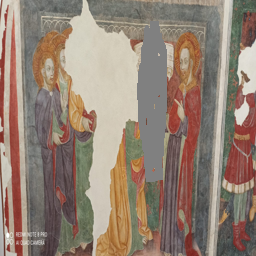

In [27]:
# Source image we are inpainting
source_image_256 = read_image(uploaded_image, size=256)
source_image_64 = read_image(uploaded_image, size=64)

# The mask should always be a boolean 64x64 mask, and then we
# can upsample it for the second stage.
source_mask_64 = read_mask('mask.png',64)
source_mask_256 = read_mask('mask.png',256)

# Visualize the image we are inpainting
show_images(source_image_256 * source_mask_256)

# Run Model

In [28]:
def run(batch_size = 9,guidance_scale=5,upsample_temp =0.997 ,fixSeed = True,prompt = "escher"):

  if fixSeed == True:
     th.manual_seed(42)

  ##############################
  # Sample from the base model #
  ##############################

  # Create the text tokens to feed to the model.
  tokens = model.tokenizer.encode(prompt)
  tokens, mask = model.tokenizer.padded_tokens_and_mask(
      tokens, options['text_ctx']
  )

  # Create the classifier-free guidance tokens (empty)
  full_batch_size = batch_size * 2
  uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
      [], options['text_ctx']
  )

  # Pack the tokens together into model kwargs.
  model_kwargs = dict(
      tokens=th.tensor(
          [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size + [uncond_mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),

      # Masked inpainting image
      inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
      inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
  )

  # Create an classifier-free guidance sampling function
  def model_fn(x_t, ts, **kwargs):
      half = x_t[: len(x_t) // 2]
      combined = th.cat([half, half], dim=0)
      model_out = model(combined, ts, **kwargs)
      eps, rest = model_out[:, :3], model_out[:, 3:]
      cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
      half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
      eps = th.cat([half_eps, half_eps], dim=0)
      return th.cat([eps, rest], dim=1)

  def denoised_fn(x_start):
      # Force the model to have the exact right x_start predictions
      # for the part of the image which is known.
      return (
          x_start * (1 - model_kwargs['inpaint_mask'])
          + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
      )

  # Sample from the base model.
  model.del_cache()
  samples = diffusion.p_sample_loop(
      model_fn,
      (full_batch_size, 3, options["image_size"], options["image_size"]),
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
      denoised_fn=denoised_fn,
  )[:batch_size]
  model.del_cache()

  # Show the output
  show_images(samples)

  ##############################
  # Upsample the 64x64 samples #
  ##############################

  tokens = model_up.tokenizer.encode(prompt)
  tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
      tokens, options_up['text_ctx']
  )

  # Create the model conditioning dict.
  model_kwargs = dict(
      # Low-res image to upsample.
      low_res=((samples+1)*127.5).round()/127.5 - 1,

      # Text tokens
      tokens=th.tensor(
          [tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),

      # Masked inpainting image.
      inpaint_image=(source_image_256 * source_mask_256).repeat(batch_size, 1, 1, 1).to(device),
      inpaint_mask=source_mask_256.repeat(batch_size, 1, 1, 1).to(device),
  )

  def denoised_fn(x_start):
      # Force the model to have the exact right x_start predictions
      # for the part of the image which is known.
      return (
          x_start * (1 - model_kwargs['inpaint_mask'])
          + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
      )

  # Sample from the base model.
  model_up.del_cache()
  up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
  up_samples = diffusion_up.p_sample_loop(
      model_up,
      up_shape,
      noise=th.randn(up_shape, device=device) * upsample_temp,
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
      denoised_fn=denoised_fn,
  )[:batch_size]
  model_up.del_cache()

  # Show output
  print("Prompt used:",prompt)
  show_images(source_image_256)
  show_images(source_image_256 * source_mask_256)
  show_images(up_samples)
  save_images(up_samples,batch_size = batch_size) #split and save to local folder
  #files.download('mask.png')  #save the mask as it is a seed



Implement a form to set the values for the sampling parameters.

In [15]:
#@title Parameters
_prompt = "building" #@param {type: "string"}

#@markdown This parameter determines the number of outputs
batch =  3 #@param {type: "number"}

#@markdown Guidance_scale is how much the text-conditioned part controls the model's output. If the outputs are pure noise at high resolution for example you can set it higher

guidance =   7#@param {type: "number"}

#@markdown upsample temp <br>
#@markdown Tune this parameter to control the sharpness of 256x256 images.
#@markdown <br>A value of 1.0 is sharper, but sometimes results in grainy artifacts.
temp =  0.997#@param {type: "number"}

#@markdown model seed - Set it to False for rnd seed<br>
seed     = False #@param 


### Run the model

  0%|          | 0/100 [00:00<?, ?it/s]

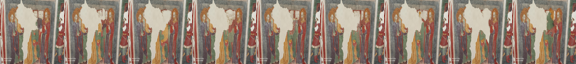

  0%|          | 0/27 [00:00<?, ?it/s]

Prompt used: building


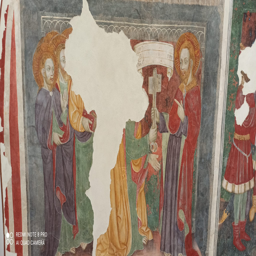

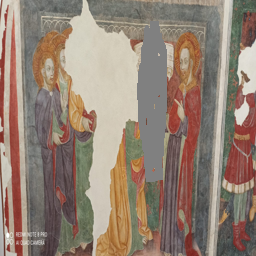

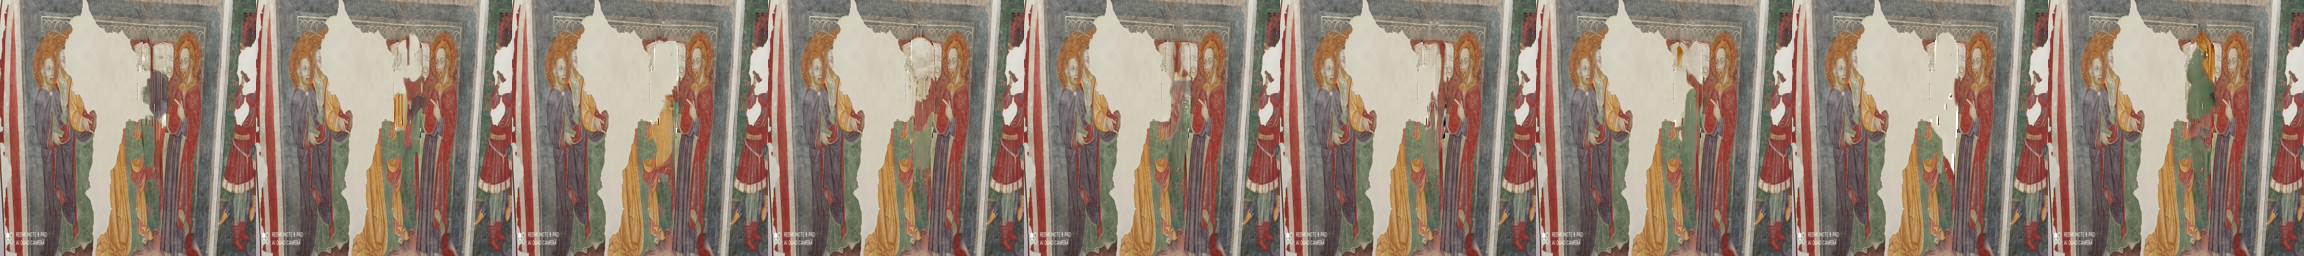

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
run(batch_size = batch,guidance_scale = guidance, upsample_temp  = temp,fixSeed = seed, prompt = _prompt)


Delete saved files for peace of mind

In [19]:
# Delete saved files for peace of mind
!rm -rf out*